## Data loading and preprocessing

### Import Libraries

In [2]:
# Импорт библиотек
import numpy as np
import pandas as pd

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency


### Download data

In [7]:
sample_df = pd.read_csv('playground-series-s6e2/sample_submission.csv')
sample_df.head()

,id,Heart Disease
0,630000,0
1,630001,0
2,630002,0
3,630003,0
4,630004,0


In [ ]:
# read data
df = pd.read_csv('playground-series-s6e2/train.csv')
df.head()

,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,Presence
1,1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,Absence
2,2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,Absence
3,3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,Absence
4,4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,Presence


In [ ]:
# targeting into 0/1

df['Heart Disease'] = df['Heart Disease'].replace({'Presence': 1, 'Absence': 0})
df.head()

,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,1
1,1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,0
2,2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,0
3,3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,0
4,4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,1


In [59]:
# 1. Общий обзор: сколько пропусков в каждом столбце
print("Пропущенные значения по столбцам:")
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
if len(missing) == 0:
    print("✅ Пропусков нет!")
else:
    print(missing)
    print(f"\nВсего пропущенных ячеек: {df.isnull().sum().sum()} из {df.size} ({df.isnull().sum().sum() / df.size * 100:.2f}%)")


Пропущенные значения по столбцам:
✅ Пропусков нет!


### Distributions of numerical characteristics

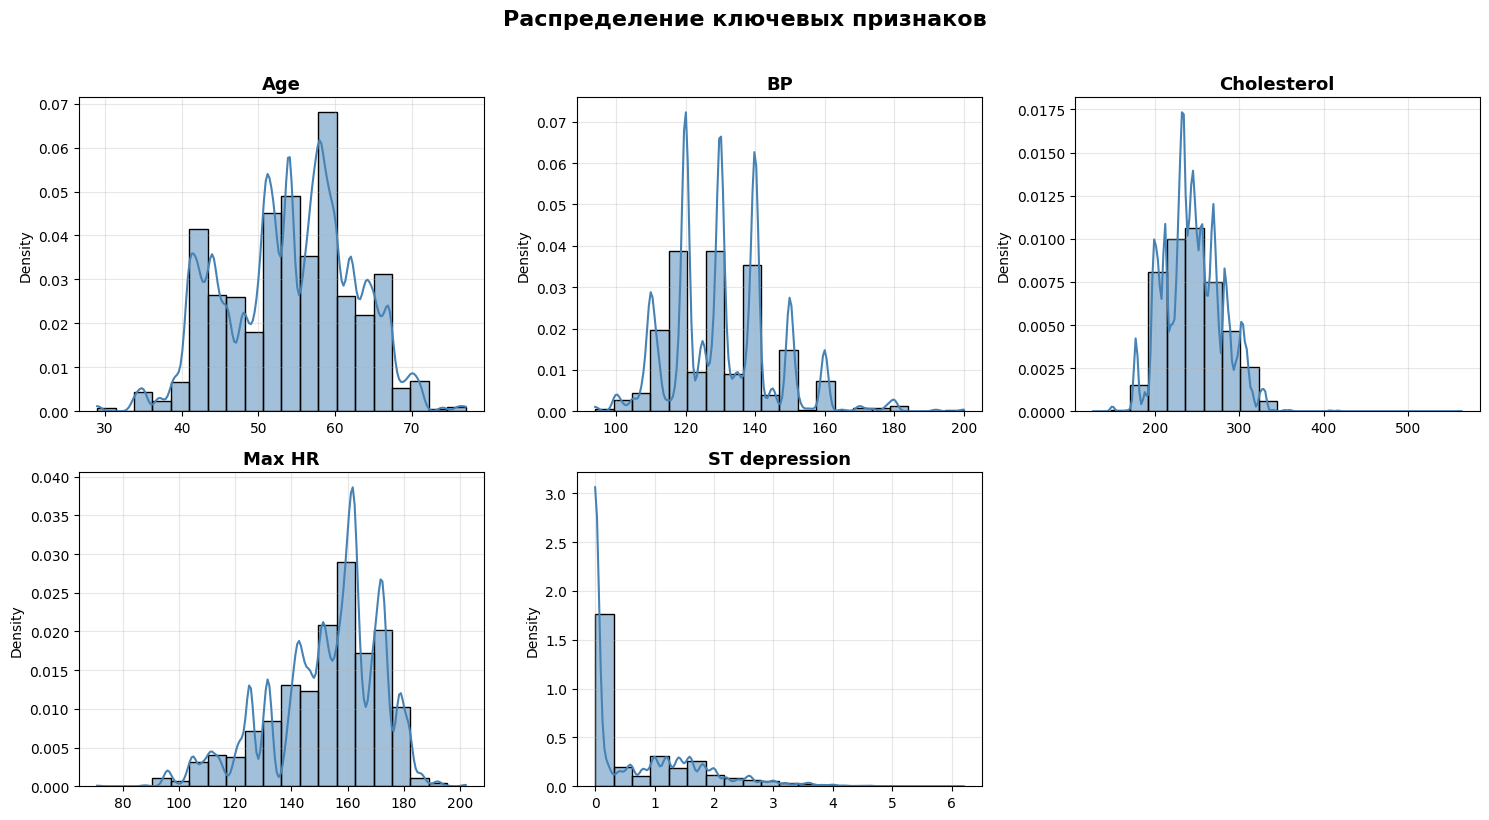

In [37]:
fields = ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']

# Автоматический расчёт сетки: 3 столбца, строки подстраиваются
ncols = 3
nrows = (len(fields) + ncols - 1) // ncols  # Округление вверх

fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))
axes = axes.flatten()

for idx, field in enumerate(fields):
    sns.histplot(df[field], bins=20, kde=True, color='steelblue', stat='density', ax=axes[idx])
    axes[idx].set_title(field, fontsize=13, fontweight='bold')
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('Density')
    axes[idx].grid(alpha=0.3)

# Скрыть пустые оси, если полей меньше, чем ячеек сетки
for idx in range(len(fields), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Распределение ключевых признаков', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

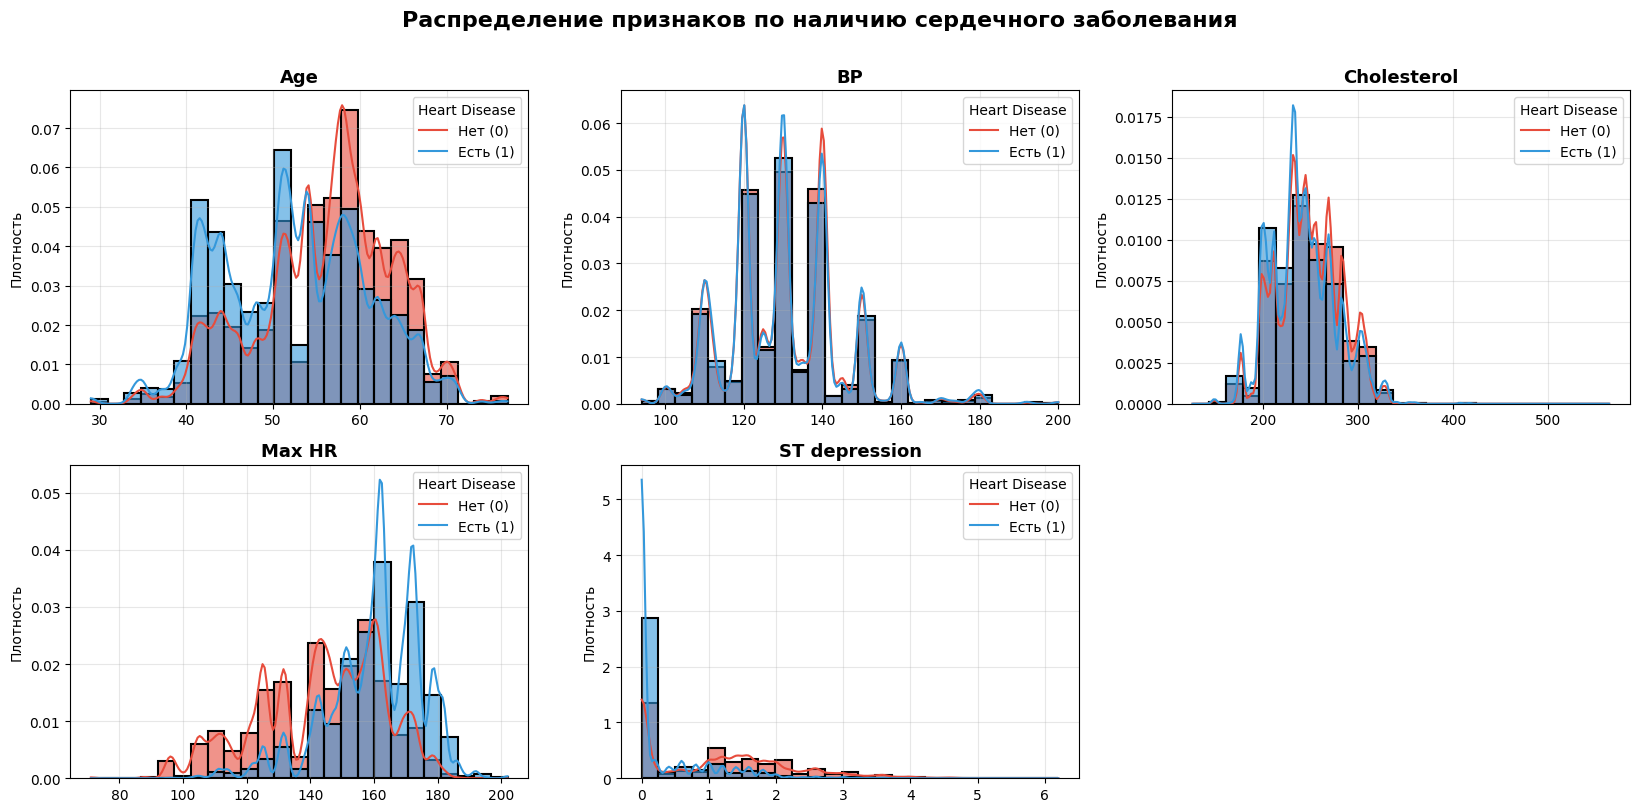

In [39]:
# Список числовых признаков для анализа
numeric_fields = ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']
# Автоматический расчёт сетки (3 столбца)
ncols = 3
nrows = (len(numeric_fields) + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(5.5 * ncols, 4 * nrows))
axes = axes.flatten()

# Палитра: 0 = синий (здоровые), 1 = красный (заболевание)
palette = {0: '#3498db', 1: '#e74c3c'}

for idx, field in enumerate(numeric_fields):
    sns.histplot(
        data=df,
        x=field,
        hue='Heart Disease',
        bins=25,
        kde=True,
        stat='density',
        common_norm=False,      # Нормализация внутри каждого класса
        palette=palette,
        alpha=0.6,
        linewidth=1.5,
        ax=axes[idx]
    )
    axes[idx].set_title(f'{field}', fontsize=13, fontweight='bold')
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('Плотность')
    axes[idx].grid(alpha=0.3)
    axes[idx].legend(title='Heart Disease', labels=['Нет (0)', 'Есть (1)'])

# Скрыть пустые оси
for idx in range(len(numeric_fields), len(axes)):
    axes[idx].set_visible(False)

# Общая подпись
fig.suptitle('Распределение признаков по наличию сердечного заболевания', 
             fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

In [40]:
def analyze_categorical(feature, df, target='Heart Disease'):
    # Абсолютные значения
    crosstab = pd.crosstab(df[feature], df[target], margins=True)
    
    # Проценты по строкам (доля классов внутри категории)
    crosstab_pct = pd.crosstab(df[feature], df[target], normalize='index') * 100
    
    # Объединяем таблицы
    result = pd.concat([
        crosstab.iloc[:-1],  # Без итоговой строки
        crosstab_pct.round(1).add_suffix('_pct')
    ], axis=1)
    
    # Добавляем долю заболевания (класс 1) для сортировки
    result['disease_rate'] = crosstab_pct[1]
    result = result.sort_values('disease_rate', ascending=False)
    
    print(f"\n=== Анализ признака: {feature} ===")
    print(result.drop(columns=['disease_rate']))
    
    return result

# Пример использования
result = analyze_categorical('Chest pain type', df)


=== Анализ признака: Chest pain type ===
Heart Disease         0       1     All  0_pct  1_pct
Chest pain type                                      
4                 99584  229595  329179   30.3   69.7
3                159664   37614  197278   80.9   19.1
2                 62787   12154   74941   83.8   16.2
1                 25511    3091   28602   89.2   10.8


In [41]:

# Кросс-таблица: абсолютные значения
crosstab = pd.crosstab(df['Sex'], df['Heart Disease'], margins=True)
print("=== Абсолютные значения ===")
print(crosstab)

# Проценты по строкам (доля заболевания внутри пола)
crosstab_pct = pd.crosstab(df['Sex'], df['Heart Disease'], normalize='index') * 100
print("\n=== Проценты по строкам (доля заболевания внутри пола) ===")
print(crosstab_pct.round(1))

# Общая статистика
total_men = (df['Sex'] == 'M').sum()
total_women = (df['Sex'] == 'F').sum()
disease_men = ((df['Sex'] == 'M') & (df['Heart Disease'] == 1)).sum()
disease_women = ((df['Sex'] == 'F') & (df['Heart Disease'] == 1)).sum()

print(f"\n📊 Общая статистика:")
print(f"Мужчин: {total_men} ({total_men/len(df)*100:.1f}%) → Заболевание: {disease_men} ({disease_men/total_men*100:.1f}%)")
print(f"Женщин: {total_women} ({total_women/len(df)*100:.1f}%) → Заболевание: {disease_women} ({disease_women/total_women*100:.1f}%)")
print(f"Разница в доле заболевания: {abs(disease_men/total_men - disease_women/total_women)*100:.1f} процентных пункта")

=== Абсолютные значения ===
Heart Disease       0       1     All
Sex                                  
0              147590   32127  179717
1              199956  250327  450283
All            347546  282454  630000

=== Проценты по строкам (доля заболевания внутри пола) ===
Heart Disease     0     1
Sex                      
0              82.1  17.9
1              44.4  55.6

📊 Общая статистика:
Мужчин: 0 (0.0%) → Заболевание: 0 (nan%)
Женщин: 0 (0.0%) → Заболевание: 0 (nan%)
Разница в доле заболевания: nan процентных пункта


C:\Users\metel\AppData\Local\Temp\ipykernel_17836\1346765495.py:18: RuntimeWarning: invalid value encountered in scalar divide
  print(f"Мужчин: {total_men} ({total_men/len(df)*100:.1f}%) → Заболевание: {disease_men} ({disease_men/total_men*100:.1f}%)")
C:\Users\metel\AppData\Local\Temp\ipykernel_17836\1346765495.py:19: RuntimeWarning: invalid value encountered in scalar divide
  print(f"Женщин: {total_women} ({total_women/len(df)*100:.1f}%) → Заболевание: {disease_women} ({disease_women/total_women*100:.1f}%)")
C:\Users\metel\AppData\Local\Temp\ipykernel_17836\1346765495.py:20: RuntimeWarning: invalid value encountered in scalar divide
  print(f"Разница в доле заболевания: {abs(disease_men/total_men - disease_women/total_women)*100:.1f} процентных пункта")


In [45]:
# Посмотреть уникальные значения и их распределение
print("Уникальные значения в 'Sex':", df['Sex'].unique())
print("\nРаспределение:")
print(df['Sex'].value_counts().sort_index())

# Проверить связь с целевой переменной
print("\nДоля сердечных заболеваний по значениям Sex:")
print(df.groupby('Sex')['Heart Disease'].mean().round(3) * 100)

Уникальные значения в 'Sex': [1 0]

Распределение:
Sex
0    179717
1    450283
Name: count, dtype: int64

Доля сердечных заболеваний по значениям Sex:
Sex
0    17.9
1    55.6
Name: Heart Disease, dtype: object


In [ ]:

def plot_categorical_features(df, features, target='Heart Disease', ncols=3):
    """
    Строит двойные графики для категориальных признаков:
    - Слева: распределение по классам (абсолютные числа)
    - Справа: доля заболевания в каждой категории (%)
    """
    nrows = (len(features) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols * 2, figsize=(6 * ncols, 4.5 * nrows))
    axes = axes.reshape(nrows, ncols * 2)  # Для удобной индексации
    
    # Цвета: 0 = синий (здоровые), 1 = красный (заболевание)
    palette = {0: '#3498db', 1: '#e74c3c'}
    
    for row in range(nrows):
        for col in range(ncols):
            idx = row * ncols + col
            if idx >= len(features):
                # Скрыть лишние оси
                if col * 2 < axes.shape[1]:
                    axes[row, col * 2].set_visible(False)
                    axes[row, col * 2 + 1].set_visible(False)
                continue
            
            feature = features[idx]
            ax_left = axes[row, col * 2]
            ax_right = axes[row, col * 2 + 1]
            
            # === Левый график: распределение по классам ===
            sns.countplot(
                data=df,
                x=feature,
                hue=target,
                palette=palette,
                order=sorted(df[feature].dropna().unique()),
                ax=ax_left
            )
            ax_left.set_title(f'{feature}', fontsize=13, fontweight='bold')
            ax_left.set_xlabel('')
            ax_left.set_ylabel('Количество')
            ax_left.legend(title=target, labels=['Нет (0)', 'Есть (1)'])
            ax_left.grid(axis='y', alpha=0.3)
            
            # Добавить подписи значений
            for container in ax_left.containers:
                ax_left.bar_label(container, fmt='%d', padding=2, fontsize=8)
            
            # === Правый график: доля заболевания ===
            disease_rate = df.groupby(feature)[target].mean().sort_index() * 100
            overall_rate = df[target].mean() * 100
            
            bars = sns.barplot(
                x=disease_rate.index,
                y=disease_rate.values,
                palette=['#2ecc71' if x < overall_rate else '#e74c3c' 
                         for x in disease_rate.values],
                ax=ax_right
            )
            ax_right.axhline(y=overall_rate, color='gray', linestyle='--', 
                            linewidth=1.5, label=f'Среднее: {overall_rate:.1f}%')
            ax_right.set_title(f'{feature}\n(доля заболевания)', 
                             fontsize=13, fontweight='bold')
            ax_right.set_xlabel('')
            ax_right.set_ylabel('Доля (%)')
            ax_right.set_ylim(0, max(100, disease_rate.max() * 1.15))
            ax_right.legend(fontsize=9)
            ax_right.grid(axis='y', alpha=0.3)
            
            # Добавить точные значения на столбцах
            for i, (cat, rate) in enumerate(disease_rate.items()):
                color = 'white' if rate > 60 else 'black'
                ax_right.text(i, rate + 2, f'{rate:.1f}%', 
                            ha='center', fontsize=9, fontweight='bold', color=color)
            
            # Статистическая значимость (под графиком)
            contingency = pd.crosstab(df[feature], df[target])
            chi2, p, _, _ = chi2_contingency(contingency)
            sign = '✅' if p < 0.05 else '⚠️'
            ax_right.text(0.5, -0.25, f'{sign} p={p:.3f}', 
                        ha='center', transform=ax_right.transAxes,
                        fontsize=9, style='italic')
    
    # Общая подпись
    fig.suptitle('Анализ категориальных признаков по целевой переменной', 
                fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

C:\Users\metel\AppData\Local\Temp\ipykernel_17836\2207393818.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(
C:\Users\metel\AppData\Local\Temp\ipykernel_17836\2207393818.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(
C:\Users\metel\AppData\Local\Temp\ipykernel_17836\2207393818.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(
C:\Users\metel\AppData\Local\Temp\ipykernel_17836\2207393818.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign t

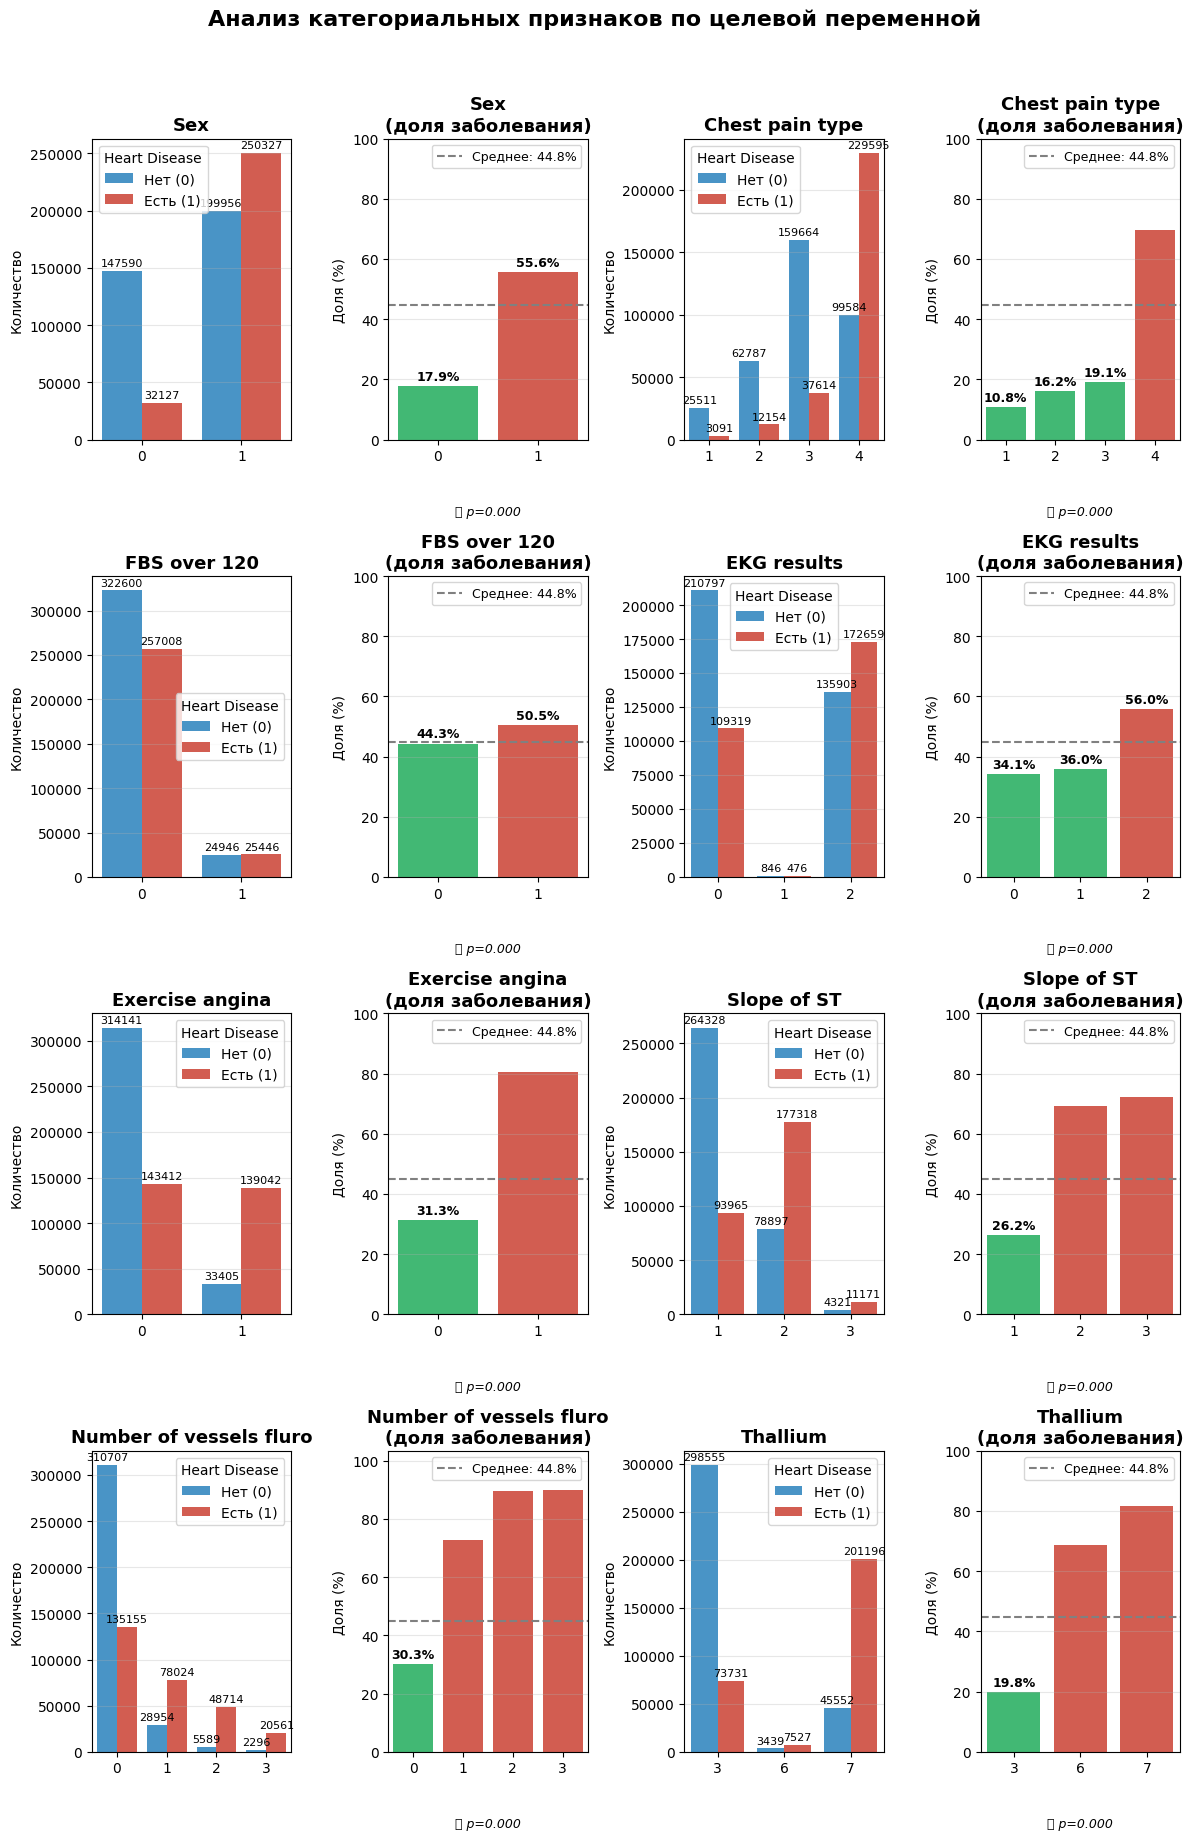

In [52]:
plot_categorical_features(df, ['Sex', 'Chest pain type', 'FBS over 120', 'EKG results', 'Exercise angina', 'Slope of ST',	'Number of vessels fluro',	'Thallium'], target='Heart Disease', ncols=2)

In [58]:
print('Распределение по категориальным признакам:')
for param in ['Sex', 'Chest pain type', 'FBS over 120', 'EKG results', 
              'Exercise angina', 'Slope of ST', 'Number of vessels fluro', 'Thallium']:
    
    # print(f"\n{'='*60}")
    print(f"\033[94m{param}\033[0m")
    # print('='*60)
    
    # Количество по значениям
    counts = df[param].value_counts().sort_index()
    
    # Доля заболевания по значениям (в процентах)
    disease_rates = (df.groupby(param)['Heart Disease'].mean() * 100).round(1)
    
    # Выводим вместе
    for value in counts.index:
        count = counts[value]
        rate = disease_rates.get(value, 0)
        print(f"{value:<5} | кол-во: {count:<8} | заболевание: {rate:>5.1f}%")

Распределение по категориальным признакам:
Sex
0     | кол-во: 179717   | заболевание:  17.9%
1     | кол-во: 450283   | заболевание:  55.6%
Chest pain type
1     | кол-во: 28602    | заболевание:  10.8%
2     | кол-во: 74941    | заболевание:  16.2%
3     | кол-во: 197278   | заболевание:  19.1%
4     | кол-во: 329179   | заболевание:  69.7%
FBS over 120
0     | кол-во: 579608   | заболевание:  44.3%
1     | кол-во: 50392    | заболевание:  50.5%
EKG results
0     | кол-во: 320116   | заболевание:  34.1%
1     | кол-во: 1322     | заболевание:  36.0%
2     | кол-во: 308562   | заболевание:  56.0%
Exercise angina
0     | кол-во: 457553   | заболевание:  31.3%
1     | кол-во: 172447   | заболевание:  80.6%
Slope of ST
1     | кол-во: 358293   | заболевание:  26.2%
2     | кол-во: 256215   | заболевание:  69.2%
3     | кол-во: 15492    | заболевание:  72.1%
Number of vessels fluro
0     | кол-во: 445862   | заболевание:  30.3%
1     | кол-во: 106978   | заболевание:  72.9%
2     | кол-во

## Матрица корреляций

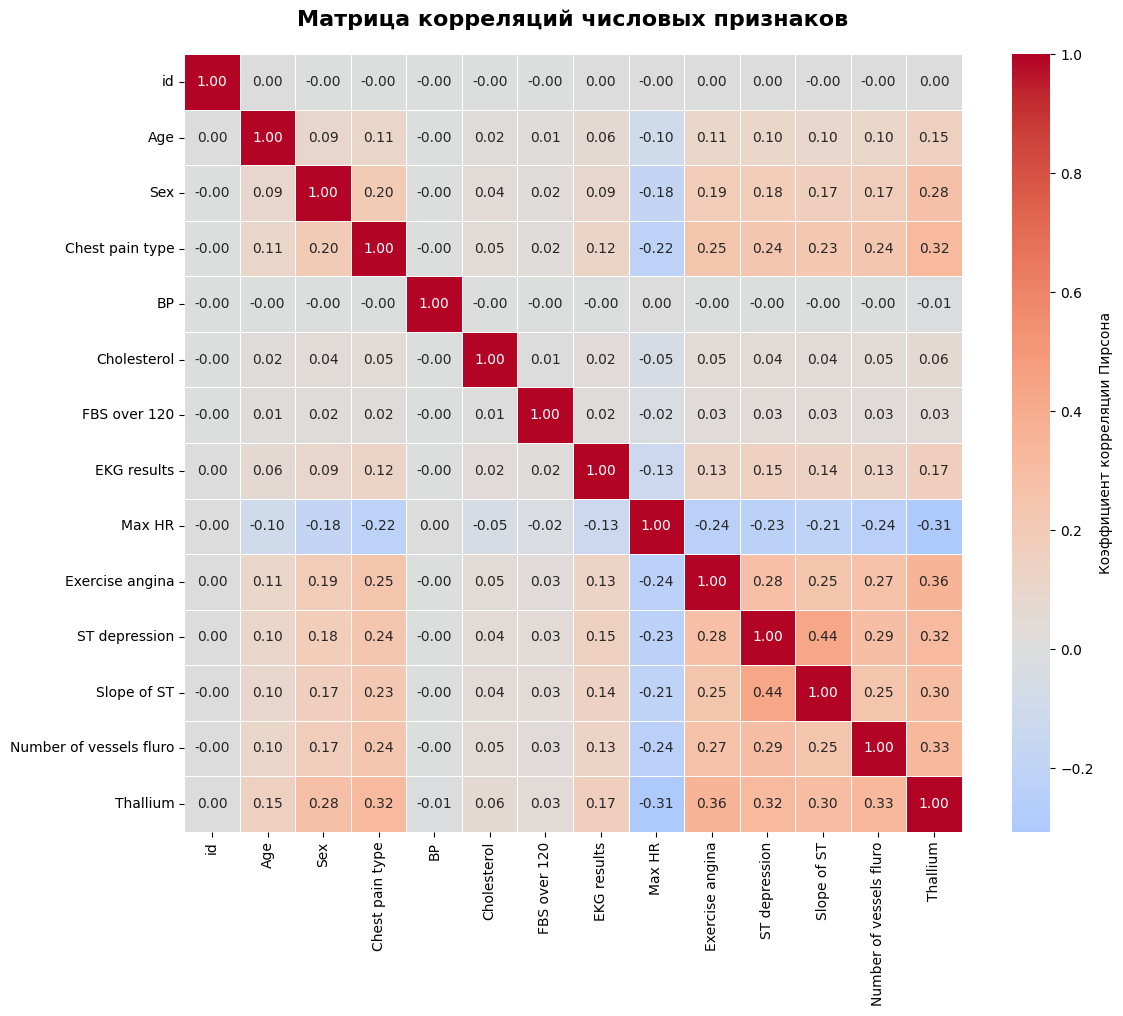

In [ ]:
# Выбираем только числовые столбцы (включая бинарные 0/1)
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Вычисляем матрицу корреляций (Пирсон)
corr = numeric_df.corr()

# Строим тепловую карту
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    annot=True,               # Показывать числа в ячейках
    fmt='.2f',                # Формат: 2 знака после запятой
    cmap='coolwarm',          # Синий = отрицательная, красный = положительная
    center=0,                 # Центр цветовой шкалы = 0
    square=True,              # Квадратные ячейки
    linewidths=0.5,           # Линии между ячейками
    cbar_kws={'label': 'Коэффициент корреляции Пирсона'}
)

plt.title('Матрица корреляций числовых признаков', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [77]:
# corr_no_diag = corr.copy()
# np.fill_diagonal(corr_no_diag.values, np.nan)

corr_no_diag = corr.values.copy()
np.fill_diagonal(corr_no_diag, 0)

In [79]:
corr_no_diag.min()

np.float64(-0.30691226598645616)